# Rainfall Prediction Using Machine Learning

### Packages

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score
#models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


### Data preprocessing functions

In [2]:
def drop_redundant_cols(df, target, thres):
    dropped_features = []
    for col in list(set(df.columns.to_list()) - set(['index', target])):
        
        feature_val_count = pd.DataFrame(data.groupby([col]).count())
        
        if feature_val_count['index'].max() > thres * feature_val_count['index'].sum():
            print('Redundant feature: ', col)
            dropped_features.append(col)
            df = df.drop(columns = [col], axis=1)
    
    return df, dropped_features

In [3]:
def drop_highly_correlated_features(x_df, y_df, num_data, target, corr_thres):
    
    dropped_features = []
    
    num_cols_wthout_response_var = num_data                 #list(set(num_data) - set([target]))
    corr_matrix = x_df[num_cols_wthout_response_var].corr() 

    for row_idx in range(corr_matrix.shape[0]):
        for col_idx in range(row_idx + 1, corr_matrix.shape[0]):
            
            if num_cols_wthout_response_var[row_idx] in x_df.columns and num_cols_wthout_response_var[col_idx] in x_df.columns:
                if(np.abs(corr_matrix.values[row_idx, col_idx]) > corr_thres):
                    var_row_corr_wth_response = np.abs(np.corrcoef(y_df[target],
                                                                   x_df[num_cols_wthout_response_var[row_idx]])[0, 1]) 

                    var_col_corr_wth_response = np.abs(np.corrcoef(y_df[target],
                                                                   x_df[num_cols_wthout_response_var[col_idx]])[0, 1]) 

                    if var_row_corr_wth_response > var_col_corr_wth_response:
                        print('Dropping ', num_cols_wthout_response_var[col_idx])
                        x_df = x_df.drop(columns = [num_cols_wthout_response_var[col_idx]])
                        dropped_features.append(num_cols_wthout_response_var[col_idx])
                        

                    else: 
                        print('Dropping ', num_cols_wthout_response_var[row_idx]) 
                        x_df = x_df.drop(columns = [num_cols_wthout_response_var[row_idx]]) 
                        dropped_features.append(num_cols_wthout_response_var[row_idx])
    
    num_data = list(set(num_data) - set(dropped_features))       
    return x_df, num_data, dropped_features

In [4]:
# outliers
def clamp_outliers_fit(df, col, coeff):
    
    # IQR
    Q1 = np.percentile(df[col], 25, interpolation = 'midpoint')

    Q3 = np.percentile(df[col], 75, interpolation = 'midpoint')

    IQR = Q3 - Q1

    # Upper bound
    upper_bound = Q3 + coeff * IQR

    # Lower bound
    lower_bound = Q1 - coeff * IQR
    
    return upper_bound, lower_bound

def clamp_outliers_transform(df, col, upper_bound, lower_bound):

    df[col].mask(df[col] > upper_bound, upper_bound, inplace=True)
    df[col].mask(df[col] < lower_bound, lower_bound, inplace=True)
    
    return df

def clamp_outliers(train_df, test_df, num_data, coeff):
    for col in num_data:
        upper_bound, lower_bound = clamp_outliers_fit(train_df, col, coeff)
        train_df = clamp_outliers_transform(train_df, col, upper_bound, lower_bound)
        test_df = clamp_outliers_transform(test_df, col, upper_bound, lower_bound)
    
    return train_df, test_df

In [5]:
def skewness_coeff(df, feature):
    skew_coeff = sum((df[feature] - df[feature].mean()) ** 3) / ((df[feature].shape[0] - 1) * df[feature].std() ** 3)

    return skew_coeff

In [6]:
def log_transform(df_train, df_test, num_data):
    print("\n\n######## Skewness coefficients of each feature ########\n")
    skew_coeffs = []
    
    for feature in num_data:
        skew_coeffs.append(skewness_coeff(df_train, feature))
        print(feature, ": ", skew_coeffs[-1])
    
    print("\n\n######## Applying log-transform to skewed features ########\n")
    transformed_features = []
    
    for i, feature in enumerate(num_data):
        if abs(skew_coeffs[i]) > 1:
            print("log-transformed feature:", feature)
            transformed_features.append(feature)
            
            df_train[feature] = np.log(np.abs(df_train[feature]+1))
            df_test[feature] = np.log(np.abs(df_test[feature]+1))
    
    return df_train, df_test, transformed_features

In [7]:
def Shapiro_Wilk_test(df, num_data, alpha):
    """ Testing the normally distributed features using Shapiro-Wilk test
    the null hypothesis here is that the data follows a normal distribution
    we reject the null hypothesis (aka: data is not normally distributed) if the p-value is less than alpha (typically 5%)
    and we fail to reject the null hypothesis (aka: data is normally distributes) if the p-value is greater than alpha """
    
    feats_std_scale = []
    feats_min_max_scale = []
    
    from scipy.stats import shapiro
    
    print("\n\n######## Shapiro Wilk test ########\n")
    
    for col in num_data:
        stat, p = shapiro(df[col])
        print('W_Statistic = %.3f, p = %.8f' % (stat, p))

        if p > alpha:
            print(f'{col} is normally distributed, so standard scaling is applied')
            feats_std_scale.append(col)
        else:
            print(f'{col} is not normally distributed, so min-max scaling is applied')
            feats_min_max_scale.append(col)
    
    return feats_min_max_scale, feats_std_scale

In [8]:
# To be modified later
def Rescale_features(df_train, df_test, feats_min_max_scale, feats_std_scale):
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.preprocessing import StandardScaler


    if len(feats_min_max_scale) != 0:
        min_max_scaler = MinMaxScaler()
        min_max_scaler_model = min_max_scaler.fit(df_train[feats_min_max_scale].to_numpy())
        min_max_scaled_train_data = pd.DataFrame(min_max_scaler_model.transform(df_train[feats_min_max_scale].to_numpy()), columns = feats_min_max_scale)
        min_max_scaled_test_data = pd.DataFrame(min_max_scaler_model.transform(df_test[feats_min_max_scale].to_numpy()), columns = feats_min_max_scale)

    if len(feats_std_scale) != 0:
        std_scaler = StandardScaler()
        std_scaler_model = std_scaler.fit(df_train[feats_std_scale].to_numpy())
        std_scaled_train_data = pd.DataFrame(std_scaler_model.transform(df_train[feats_std_scale].to_numpy()), columns = feats_std_scale)
        std_scaled_test_data = pd.DataFrame(std_scaler_model.transform(df_test[feats_std_scale].to_numpy()), columns = feats_std_scale)

    if len(feats_min_max_scale) == 0:
        num_train_df = std_scaled_train_data
        num_test_df = std_scaled_test_data
        
    elif len(feats_std_scale) == 0:
        num_train_df = min_max_scaled_train_data
        num_test_df = min_max_scaled_test_data

    else:
        num_train_df = std_scaled_train_data.merge(min_max_scaled_train_data, right_index = True, left_index = True)
        num_test_df = std_scaled_test_data.merge(min_max_scaled_test_data, right_index = True, left_index = True)
        
    return num_train_df, num_test_df

In [9]:
def merge_data(num_df, nominal_df):
    
    processed_df = nominal_df.merge(num_df, right_index = True, left_index = True, how = 'inner')
    
    return processed_df

In [10]:
def auto_preprocess_data(train_df, train_y_df, test_df, numerical_features, nominal_catg_features, target, clamping_outliers_coeff=3, corr_thres=0.7, alpha=0.05):
    
    # Categorical dataframes
    nominal_train_df, nominal_test_df = train_df[nominal_catg_features], test_df[nominal_catg_features]
    
    
    # Highly correlated features handling
    print("\n\n######## Dropping highly correlated features ########\n")
    train_df, numerical_features, highly_correlated_features = drop_highly_correlated_features(train_df, train_y_df, numerical_features, target, corr_thres)
    test_df = test_df.drop(columns = highly_correlated_features, axis=1)
    
    
    # Clamping outliers
    train_df, test_df = clamp_outliers(train_df, test_df, numerical_features, clamping_outliers_coeff)
    
    
    # Data skewness handling
    train_df, test_df, transformed_features = log_transform(train_df, test_df, numerical_features)
    
    
    # Shapiro-Wilk test, to check the distribution of the data
    feats_min_max_scale, feats_std_scale = Shapiro_Wilk_test(train_df, numerical_features, alpha)
    
    # Features rescaling
    num_train_df, num_test_df = Rescale_features(train_df, test_df, feats_min_max_scale, feats_std_scale)
    
    # Merging back all features
    processed_train_df = merge_data(num_train_df, nominal_train_df)
    processed_test_df = merge_data(num_test_df, nominal_test_df)
    
    # Total dropped features
    dropped_features = redundant_features + highly_correlated_features

    return processed_train_df, processed_test_df, dropped_features

### Loading data

In [11]:
data = pd.read_csv('weather.csv')
data

MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine WindGustDir  \
0        8.0     24.3       0.0          3.4       6.3          NW   
1       14.0     26.9       3.6          4.4       9.7         ENE   
2       13.7     23.4       3.6          5.8       3.3          NW   
3       13.3     15.5      39.8          7.2       9.1          NW   
4        7.6     16.1       2.8          5.6      10.6         SSE   
..       ...      ...       ...          ...       ...         ...   
361      9.0     30.7       0.0          7.6      12.1         NNW   
362      7.1     28.4       0.0         11.6      12.7           N   
363     12.5     19.9       0.0          8.4       5.3         ESE   
364     12.5     26.9       0.0          5.0       7.1          NW   
365     12.3     30.2       0.0          6.0      12.6          NW   

     WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  ...  Humidity3pm  \
0             30.0         SW         NW           6.0  ...           29   
1             39.0          E          W           4.0  ...           36   
2             85.0          N        NNE           6.0  ...           69   
3             54.0        WNW          W          30.0  ...           56   
4             50.0        SSE        ESE          20.0  ...           49   
..             ...        ...        ...           ...  ...          ...   
361           76.0        SSE         NW           7.0  ...           15   
362           48.0        NNW        NNW           2.0  ...           22   
363           43.0        ENE        ENE          11.0  ...           47   
364           46.0        SSW        WNW           6.0  ...           39   
365           78.0         NW        WNW          31.0  ...           13   

     Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
0         1019.7       1015.0         7         7     14.4     23.6   
1         1012.4       1008.4         5         3     17.5     25.7   
2         1009.5       1007.2         8         7     15.4     20.2   
3         1005.5       1007.0         2         7     13.5     14.1   
4         1018.3       1018.5         7         7     11.1     15.4   
..           ...          ...       ...       ...      ...      ...   
361       1016.1       1010.8         1         3     20.4     30.0   
362       1020.0       1016.9         0         1     17.2     28.2   
363       1024.0       1022.8         3         2     14.5     18.3   
364       1021.0       1016.2         6         7     15.8     25.9   
365       1009.6       1009.2         1         1     23.8     28.6   

     RainToday  RISK_MM RainTomorrow  
0           No      3.6          Yes  
1          Yes      3.6          Yes  
2          Yes     39.8          Yes  
3          Yes      2.8          Yes  
4          Yes      0.0           No  
..         ...      ...          ...  
361         No      0.0           No  
362         No      0.0           No  
363         No      0.0           No  
364         No      0.0           No  
365         No      0.0           No  

[366 rows x 22 columns]

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MinTemp        366 non-null    float64
 1   MaxTemp        366 non-null    float64
 2   Rainfall       366 non-null    float64
 3   Evaporation    366 non-null    float64
 4   Sunshine       363 non-null    float64
 5   WindGustDir    363 non-null    object 
 6   WindGustSpeed  364 non-null    float64
 7   WindDir9am     335 non-null    object 
 8   WindDir3pm     365 non-null    object 
 9   WindSpeed9am   359 non-null    float64
 10  WindSpeed3pm   366 non-null    int64  
 11  Humidity9am    366 non-null    int64  
 12  Humidity3pm    366 non-null    int64  
 13  Pressure9am    366 non-null    float64
 14  Pressure3pm    366 non-null    float64
 15  Cloud9am       366 non-null    int64  
 16  Cloud3pm       366 non-null    int64  
 17  Temp9am        366 non-null    float64
 18  Temp3pm   

In [13]:
# check duplicates
data.duplicated().sum()

0

### Handeling null values

In [14]:
# Check null values
data.isna().sum().sum()

47

In [15]:
# Checking Nulls
nulls_df = data.isna().sum().reset_index().rename(columns = {0 : 'Null count'})
nulls_df = nulls_df[nulls_df['Null count'] > 0].sort_values(by = 'Null count', ascending=False)
nulls_df = nulls_df.rename(columns = {'Null count': 'Null Percentage'})
nulls_df['Null Percentage'] = nulls_df['Null Percentage'] / data.shape[0]
nulls_df

index  Null Percentage
7     WindDir9am         0.084699
9   WindSpeed9am         0.019126
4       Sunshine         0.008197
5    WindGustDir         0.008197
6  WindGustSpeed         0.005464
8     WindDir3pm         0.002732

In [16]:
'''
Features, having null values, to be imputed: 
- WindDir9am : mode
- WindSpeed9am : Median


Features with rows, having null values, to be dropped:
- Sunshine
- WindGustDir
- WindGustSpeed
- WindDir3pm

'''

data['WindDir9am'] = data['WindDir9am'].fillna(data['WindDir9am'].mode()[0])
data['WindSpeed9am'] = data['WindSpeed9am'].fillna(data['WindSpeed9am'].median())

features_with_rows_to_be_dropped = ['Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir3pm']
data = data.dropna(axis=0, subset=features_with_rows_to_be_dropped)

# Re-check null values
data.isna().sum().sum()

0

### Dropping redundant features (if there any)

In [17]:
data = data.reset_index()
data, redundant_features = drop_redundant_cols(data, 'RainTomorrow', 0.8)

Redundant feature:  RainToday


### Categorical features encoding

In [18]:
categorical_data = ['WindGustDir', 'WindDir9am', 'WindDir3pm']
num_data = list(set(data.columns.to_list()) - set(['index', 'RainTomorrow'] + categorical_data))

In [19]:
data['WindGustDir'].unique()

array(['NW', 'ENE', 'SSE', 'SE', 'E', 'S', 'N', 'WNW', 'ESE', 'NE', 'NNE',
       'NNW', 'SW', 'W', 'WSW', 'SSW'], dtype=object)

In [20]:
data['WindDir9am'].unique()

array(['SW', 'E', 'N', 'WNW', 'SSE', 'SE', 'S', 'WSW', 'NNE', 'NNW',
       'ENE', 'SSW', 'NW', 'ESE', 'NE', 'W'], dtype=object)

In [21]:
data['WindDir3pm'].unique()

array(['NW', 'W', 'NNE', 'ESE', 'E', 'ENE', 'WSW', 'NE', 'NNW', 'SE', 'S',
       'SW', 'WNW', 'N', 'SSW', 'SSE'], dtype=object)

In [22]:
# Binary encoding for categorical data
data['RainTomorrow'] = data['RainTomorrow'].replace({'Yes': 1, 'No': 0})

import category_encoders as ce

binaryEncoder = ce.BinaryEncoder()
data = pd.concat([data, binaryEncoder.fit_transform(data[categorical_data])], axis=1)
data

index  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine WindGustDir  \
0        0      8.0     24.3       0.0          3.4       6.3          NW   
1        1     14.0     26.9       3.6          4.4       9.7         ENE   
2        2     13.7     23.4       3.6          5.8       3.3          NW   
3        3     13.3     15.5      39.8          7.2       9.1          NW   
4        4      7.6     16.1       2.8          5.6      10.6         SSE   
..     ...      ...      ...       ...          ...       ...         ...   
354    361      9.0     30.7       0.0          7.6      12.1         NNW   
355    362      7.1     28.4       0.0         11.6      12.7           N   
356    363     12.5     19.9       0.0          8.4       5.3         ESE   
357    364     12.5     26.9       0.0          5.0       7.1          NW   
358    365     12.3     30.2       0.0          6.0      12.6          NW   

     WindGustSpeed WindDir9am WindDir3pm  ...  WindDir9am_0  WindDir9am_1  \
0             30.0         SW         NW  ...             0             0   
1             39.0          E          W  ...             0             0   
2             85.0          N        NNE  ...             0             0   
3             54.0        WNW          W  ...             0             0   
4             50.0        SSE        ESE  ...             0             0   
..             ...        ...        ...  ...           ...           ...   
354           76.0        SSE         NW  ...             0             0   
355           48.0        NNW        NNW  ...             0             1   
356           43.0        ENE        ENE  ...             0             1   
357           46.0        SSW        WNW  ...             0             1   
358           78.0         NW        WNW  ...             0             1   

     WindDir9am_2  WindDir9am_3  WindDir9am_4  WindDir3pm_0  WindDir3pm_1  \
0               0             0             1             0             0   
1               0             1             0             0             0   
2               0             1             1             0             0   
3               1             0             0             0             0   
4               1             0             1             0             0   
..            ...           ...           ...           ...           ...   
354             1             0             1             0             0   
355             0             1             0             0             1   
356             0             1             1             0             0   
357             1             0             0             0             1   
358             1             0             1             0             1   

     WindDir3pm_2  WindDir3pm_3  WindDir3pm_4  
0               0             0             1  
1               0             1             0  
2               0             1             1  
3               0             1             0  
4               1             0             0  
..            ...           ...           ...  
354             0             0             1  
355             0             0             1  
356             1             1             0  
357             1             0             1  
358             1             0             1  

[359 rows x 37 columns]

In [23]:
data = data.drop(columns=categorical_data)
categorical_data = ['WindGustDir_0', 'WindGustDir_1', 'WindGustDir_2', 'WindGustDir_3', 'WindGustDir_4',
                    'WindDir9am_0', 'WindDir9am_1', 'WindDir9am_2', 'WindDir9am_3', 'WindDir9am_4',
                    'WindDir3pm_0', 'WindDir3pm_1', 'WindDir3pm_2', 'WindDir3pm_3', 'WindDir3pm_4']

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359 entries, 0 to 358
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          359 non-null    int64  
 1   MinTemp        359 non-null    float64
 2   MaxTemp        359 non-null    float64
 3   Rainfall       359 non-null    float64
 4   Evaporation    359 non-null    float64
 5   Sunshine       359 non-null    float64
 6   WindGustSpeed  359 non-null    float64
 7   WindSpeed9am   359 non-null    float64
 8   WindSpeed3pm   359 non-null    int64  
 9   Humidity9am    359 non-null    int64  
 10  Humidity3pm    359 non-null    int64  
 11  Pressure9am    359 non-null    float64
 12  Pressure3pm    359 non-null    float64
 13  Cloud9am       359 non-null    int64  
 14  Cloud3pm       359 non-null    int64  
 15  Temp9am        359 non-null    float64
 16  Temp3pm        359 non-null    float64
 17  RISK_MM        359 non-null    float64
 18  RainTomorr

### Spliting features and target

In [24]:
X = data[list(set(data.columns.to_list()) - set(['RainTomorrow']))]
y = data['RainTomorrow']

### Train/test splits

In [25]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train

WindGustDir_2  WindDir9am_3  WindGustSpeed  Humidity9am  WindSpeed3pm  \
249              0             0           59.0           76            31   
311              0             1           50.0           47            26   
340              0             1           30.0           67            11   
283              0             0           52.0           54            33   
21               1             1           26.0           88            11   
..             ...           ...            ...          ...           ...   
323              1             1           31.0           70            13   
192              1             0           20.0           80            11   
117              0             0           44.0           74            17   
47               0             1           39.0           61            20   
172              1             1           30.0           77             7   

     WindGustDir_0  WindDir3pm_4  Pressure3pm  WindDir3pm_1  WindGustDir_4  \
249              0             1       1018.2             1              1   
311              0             1       1011.4             0              1   
340              0             1       1021.5             1              1   
283              0             1       1012.4             0              0   
21               0             1       1008.9             0              1   
..             ...           ...          ...           ...            ...   
323              0             1       1026.9             1              1   
192              0             0       1021.5             1              1   
117              0             1       1014.4             0              1   
47               0             1       1018.3             0              0   
172              0             0       1021.0             0              1   

     ...  Rainfall  WindSpeed9am  Temp3pm  WindDir3pm_3  WindDir3pm_2  \
249  ...       1.6          20.0      7.1             0             1   
311  ...       0.0          20.0     25.1             0             0   
340  ...       0.0           4.0     22.3             0             0   
283  ...       0.0          28.0     12.0             0             0   
21   ...       0.4           6.0     18.3             0             1   
..   ...       ...           ...      ...           ...           ...   
323  ...       0.0           4.0     18.1             0             0   
192  ...       0.0           6.0     17.2             0             0   
117  ...       0.0           4.0     27.0             0             0   
47   ...       0.0          13.0     19.8             0             1   
172  ...       0.0           9.0     19.8             0             0   

     Evaporation  Sunshine  Pressure9am  Cloud3pm  WindDir3pm_0  
249          1.4       7.7       1016.7         3             0  
311          5.6      10.2       1015.3         1             0  
340          4.8      11.7       1025.8         4             0  
283          4.4       8.4       1014.7         3             0  
21           9.2       0.0       1010.7         8             0  
..           ...       ...          ...       ...           ...  
323          2.6      11.1       1032.2         1             0  
192          2.0       1.6       1024.4         7             0  
117          5.0      11.6       1017.6         6             0  
47           6.6       8.7       1020.6         7             0  
172          2.8      10.1       1024.8         2             1  

[287 rows x 33 columns]

In [26]:
X_train = X_train.drop(columns=['index']).reset_index().drop(columns=['index'])
X_test = X_test.drop(columns=['index']).reset_index().drop(columns=['index'])
y_train = y_train.drop(columns=['index']).reset_index().drop(columns=['index'])
y_test = y_test.drop(columns=['index']).reset_index().drop(columns=['index'])

### Handeling target class imbalance

RainTomorrow
0               233
1                54
dtype: int64


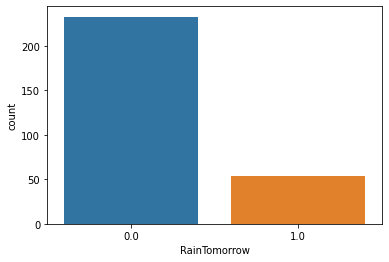

In [27]:
# Check number of samples in each class
import seaborn as sns
print(y_train.value_counts())
_ = sns.countplot(x='RainTomorrow', data=pd.concat([X_train, y_train]))

In [28]:
# Applying over/under sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

over = SMOTE(sampling_strategy = {1:180}, k_neighbors=2, random_state=42)
X_train, y_train = over.fit_resample(X_train, y_train)
under = RandomUnderSampler(sampling_strategy = {0:180}, random_state=42)
X_train, y_train = under.fit_resample(X_train, y_train)

RainTomorrow
0               180
1               180
dtype: int64


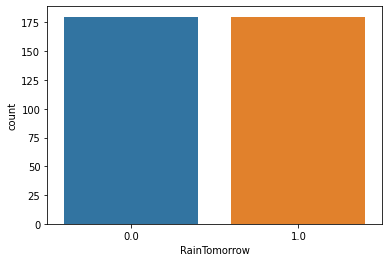

In [29]:
print(y_train.value_counts())
_ = sns.countplot(x='RainTomorrow', data=pd.concat([X_train, y_train]))

### Visuals

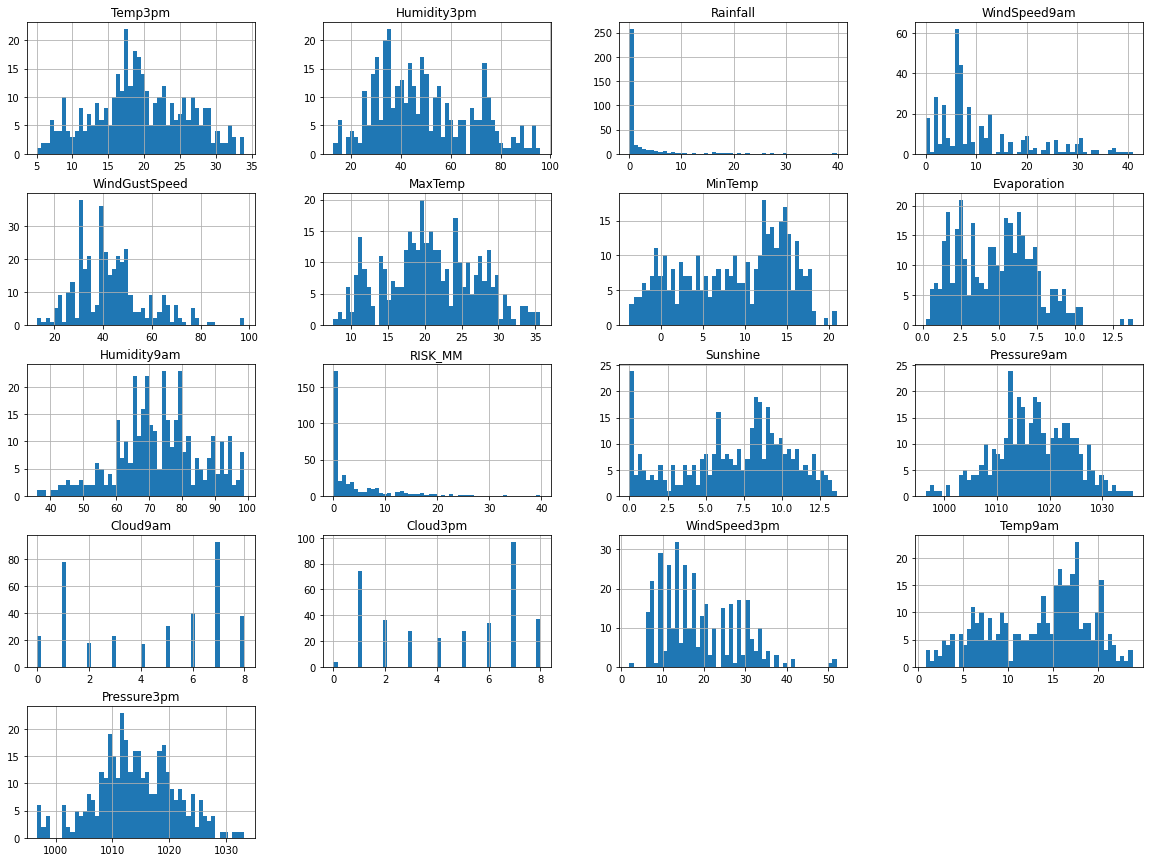

In [30]:
# Checking skewness
X_train[list(num_data)].hist(bins=50, figsize=(20, 15), layout=(5, 4));

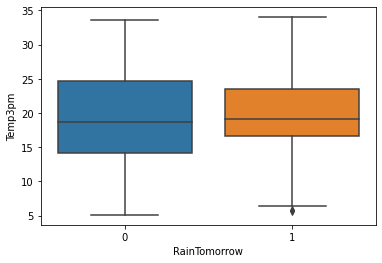

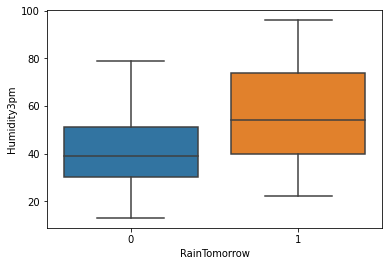

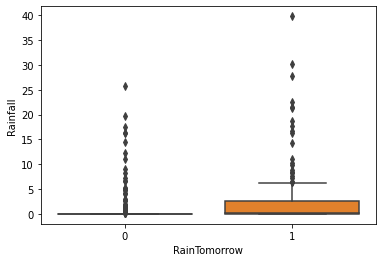

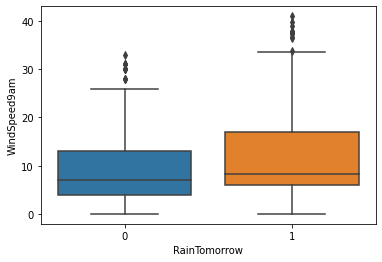

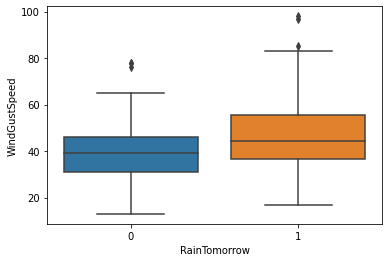

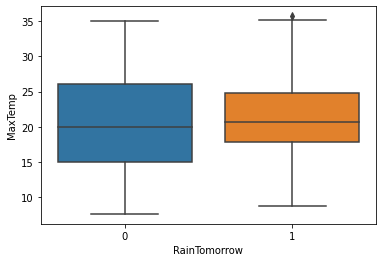

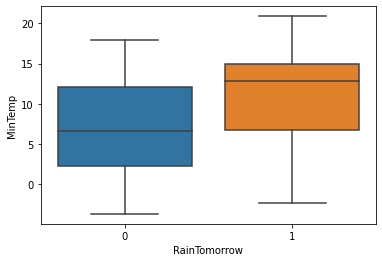

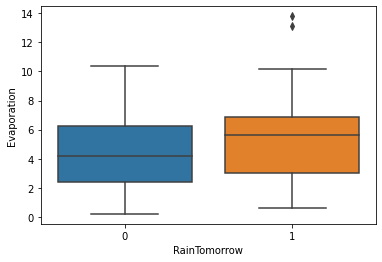

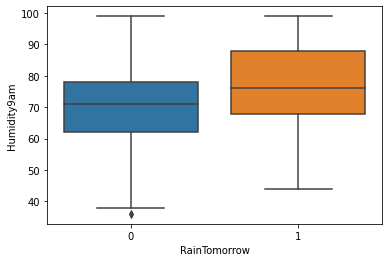

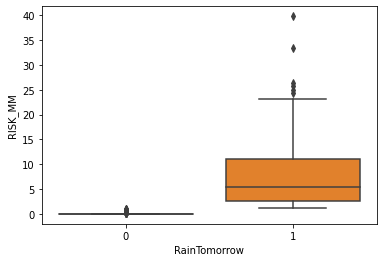

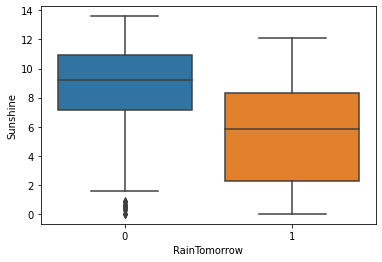

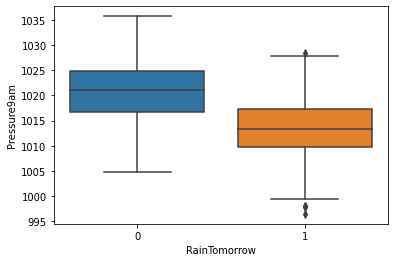

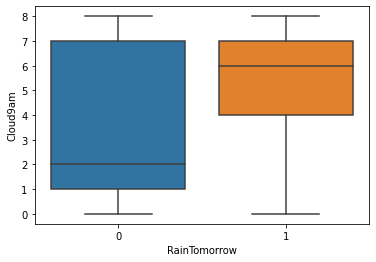

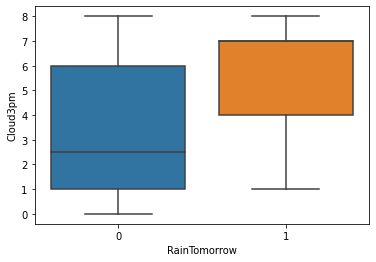

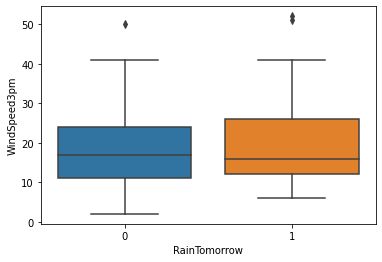

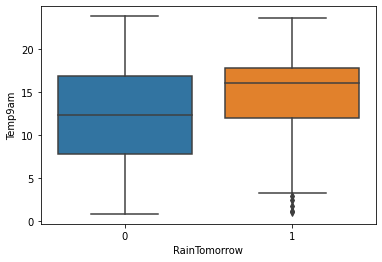

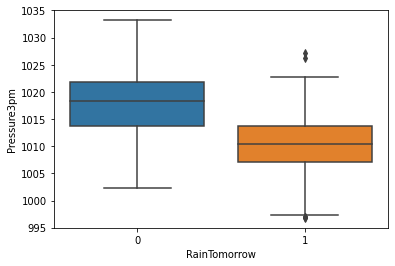

In [31]:
import matplotlib.pyplot as plt
# Checking outliears
new_data = pd.concat((X_train, y_train), axis=1)
# Checking outliears
for feature in num_data:
    sns.boxplot(x="RainTomorrow", y=feature, data=new_data)
    plt.show()

In [32]:
# Checking correlation
new_data[num_data].corr().style.background_gradient(cmap='coolwarm').set_precision(2)

C:\Users\elmog\AppData\Local\Temp/ipykernel_16548/658641665.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  new_data[num_data].corr().style.background_gradient(cmap='coolwarm').set_precision(2)


### Applying data preprocessing

In [33]:
processed_train_df, processed_test_df, dropped_features = auto_preprocess_data(X_train, 
                                                                               y_train, 
                                                                               X_test, 
                                                                               num_data, 
                                                                               categorical_data, 
                                                                               target='RainTomorrow', 
                                                                               clamping_outliers_coeff=1.5, 
                                                                               corr_thres=0.7, 
                                                                               alpha=0.001)



######## Dropping highly correlated features ########

Dropping  Temp3pm
Dropping  Humidity3pm
Dropping  MaxTemp
Dropping  Temp9am
Dropping  Cloud9am
Dropping  Pressure9am


######## Skewness coefficients of each feature ########

WindSpeed9am :  0.8502134421198355
Rainfall :  1.2532968013268833
WindGustSpeed :  0.5424567525269167
MinTemp :  -0.29714286750625885
Evaporation :  0.26998987515813133
Humidity9am :  -0.14453844653314263
RISK_MM :  1.2546497870175202
Sunshine :  -0.43368305877071067
Cloud3pm :  -0.20968261193564686
WindSpeed3pm :  0.6643268045117467
Pressure3pm :  -0.04907589484470581


######## Applying log-transform to skewed features ########

log-transformed feature: Rainfall
log-transformed feature: RISK_MM


######## Shapiro Wilk test ########

W_Statistic = 0.869, p = 0.00000000
WindSpeed9am is not normally distributed, so min-max scaling is applied
W_Statistic = 0.650, p = 0.00000000
Rainfall is not normally distributed, so min-max scaling is applied
W_Statistic = 

### Checking class separability using features pairs

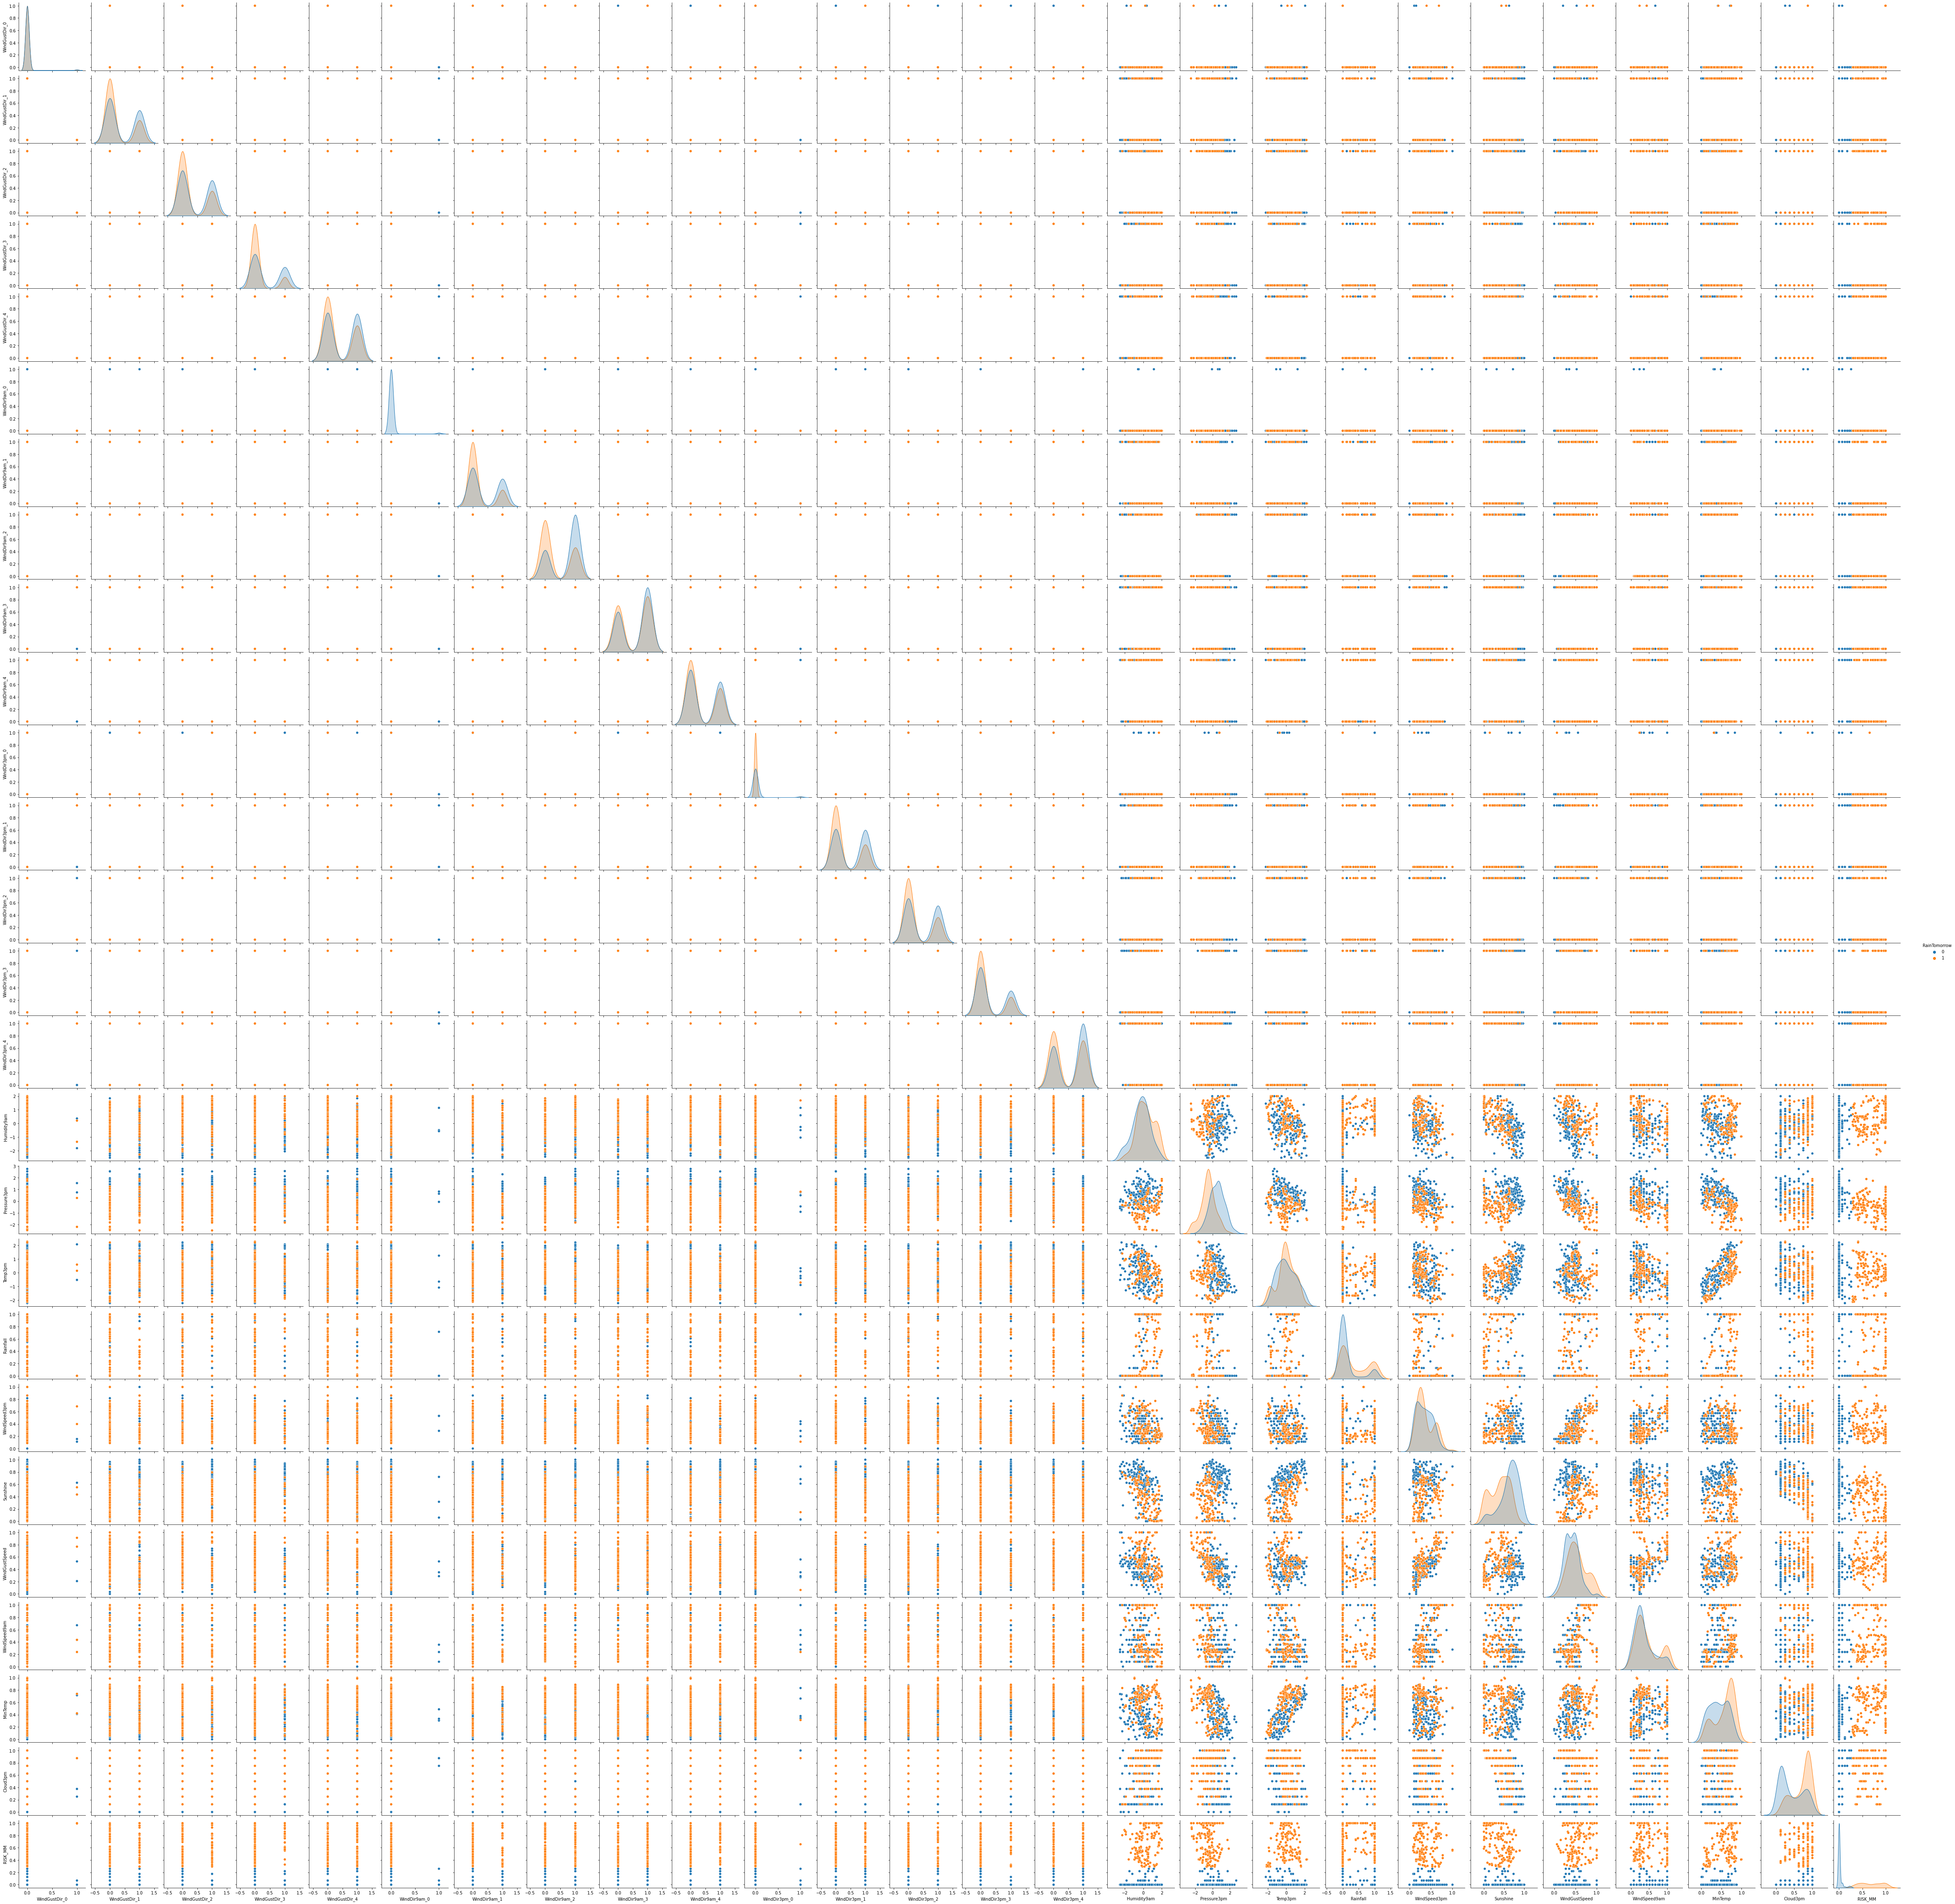

In [36]:
sns.pairplot(pd.concat((processed_train_df, y_train), axis=1), hue="RainTomorrow")

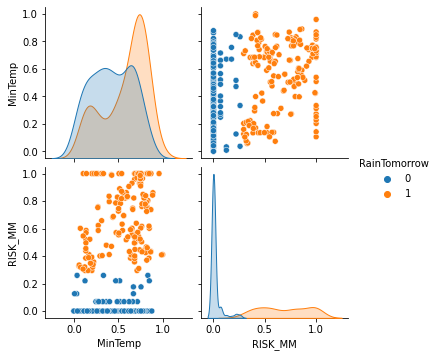

In [37]:
sns.pairplot(pd.concat((processed_train_df[['MinTemp', 'RISK_MM']], y_train), axis=1), hue="RainTomorrow")

In [34]:
# 'MinTemp', 'RISK_MM' can be used to distinguish the two classes
new_X_train = processed_train_df[['MinTemp', 'RISK_MM']]
new_X_test = processed_test_df[['MinTemp', 'RISK_MM']]

### Training models

### 1- `Logistic Regression`

AUC =  1.0


E:\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


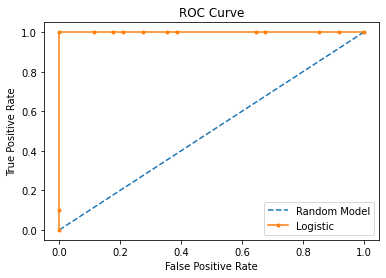

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, plot_confusion_matrix


# fit a model
model = LogisticRegression(random_state=0, max_iter=2000)
model.fit(new_X_train, y_train)

# predict probabilities
y_pred = model.predict_proba(new_X_test)

# keep probabilities for the positive outcome only
y_pred_prob = y_pred[:, [1]]

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Area under curve (AUC)
auc = roc_auc_score(y_test, y_pred_prob)

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='Random Model')
plt.plot(fpr, tpr, marker='.', label='Logistic')

# axis labels
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

print('AUC = ', auc)
# show the plot
plt.show()

In [36]:
# Classification report
print('\nTraining report:\n', classification_report(y_train, model.predict(new_X_train.values).reshape(-1, 1)))
print('\nTest report:\n', classification_report(y_test, model.predict(new_X_test.values).reshape(-1, 1)))


Training report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       180
           1       1.00      0.98      0.99       180

    accuracy                           0.99       360
   macro avg       0.99      0.99      0.99       360
weighted avg       0.99      0.99      0.99       360


Test report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00        10

    accuracy                           1.00        72
   macro avg       1.00      1.00      1.00        72
weighted avg       1.00      1.00      1.00        72



E:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
E:\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


### 2- `Support Vector Machine (SVM)`

In [37]:
# Linear Kernel SVM tuning
C = [0.01, 0.1, 1, 10, 100]
for c in C :
    
    svm  = SVC(kernel = 'linear', C = c)
    svm.fit(new_X_train.values, y_train.values.ravel())

    svm_y_train_pred = svm.predict(new_X_train.values).reshape(-1, 1)
    svm_test_pred = svm.predict(new_X_test.values).reshape(-1, 1)

    print(f'\nFor C = {c}:\n\tF1-score for train = {f1_score(y_train, svm_y_train_pred)}, and for test = {f1_score(y_test, svm_test_pred)}')


For C = 0.01:
	F1-score for train = 0.871473354231975, and for test = 0.9473684210526316

For C = 0.1:
	F1-score for train = 0.9887640449438202, and for test = 1.0

For C = 1:
	F1-score for train = 0.9836065573770492, and for test = 0.9523809523809523

For C = 10:
	F1-score for train = 0.994475138121547, and for test = 1.0

For C = 100:
	F1-score for train = 1.0, and for test = 1.0


In [38]:
# Tuned SVM
svm  = SVC(kernel = 'linear', C = 0.1)
svm.fit(new_X_train.values, y_train.values.ravel())

svm_y_train_pred = svm.predict(new_X_train.values).reshape(-1, 1)
svm_test_pred = svm.predict(new_X_test.values).reshape(-1, 1)

print('\nTraining report:\n', classification_report(y_train, svm_y_train_pred))
print('\nTest report:\n', classification_report(y_test, svm_test_pred))


Training report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       180
           1       1.00      0.98      0.99       180

    accuracy                           0.99       360
   macro avg       0.99      0.99      0.99       360
weighted avg       0.99      0.99      0.99       360


Test report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00        10

    accuracy                           1.00        72
   macro avg       1.00      1.00      1.00        72
weighted avg       1.00      1.00      1.00        72



### 3- `Decision Tree`

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


# Minimum number of samples required to split a node
min_samples_split = [x for x in range(2, 10)]

# Number of features to consider at every split
max_features = [1, 2]

# Maximum number of levels in tree
max_depth = [x for x in range(1, 5)]

# The minimum number of samples required to be at a leaf node.
min_samples_leaf = [x for x in range(1, 15)]


# Cost complexity parameter
ccp_alpha = [x for x in np.linspace(0.001, 0.01, num = 5)]

# Create the random grid
random_grid = {'min_samples_split': min_samples_split,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               'ccp_alpha': ccp_alpha}

scorer = make_scorer(f1_score)
tree_clf = DecisionTreeClassifier(random_state = 0)

In [44]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = tree_clf, 
                           param_grid = random_grid, 
                           scoring = scorer,
                           n_jobs = -1, 
                           verbose = 2).fit(new_X_train, y_train)

Fitting 5 folds for each of 4480 candidates, totalling 22400 fits


In [45]:
# Best hyperparameters from the grid search
grid_search.best_params_

{'ccp_alpha': 0.001,
 'max_depth': 1,
 'max_features': 1,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [41]:
# Tuned tree classifier
tree_clf = DecisionTreeClassifier(min_samples_split=2,
                                  max_features=1,
                                  max_depth=1,
                                  min_samples_leaf=1,
                                  ccp_alpha=0.001,
                                  random_state = 0)

tree_clf.fit(new_X_train, y_train)
tree_y_pred = tree_clf.predict(new_X_test)
print("Train F1_Score: ", f1_score(y_train, tree_clf.predict(new_X_train)))
print("Test F1_Score: ", f1_score(y_test, tree_y_pred))

Train F1_Score:  1.0
Test F1_Score:  1.0


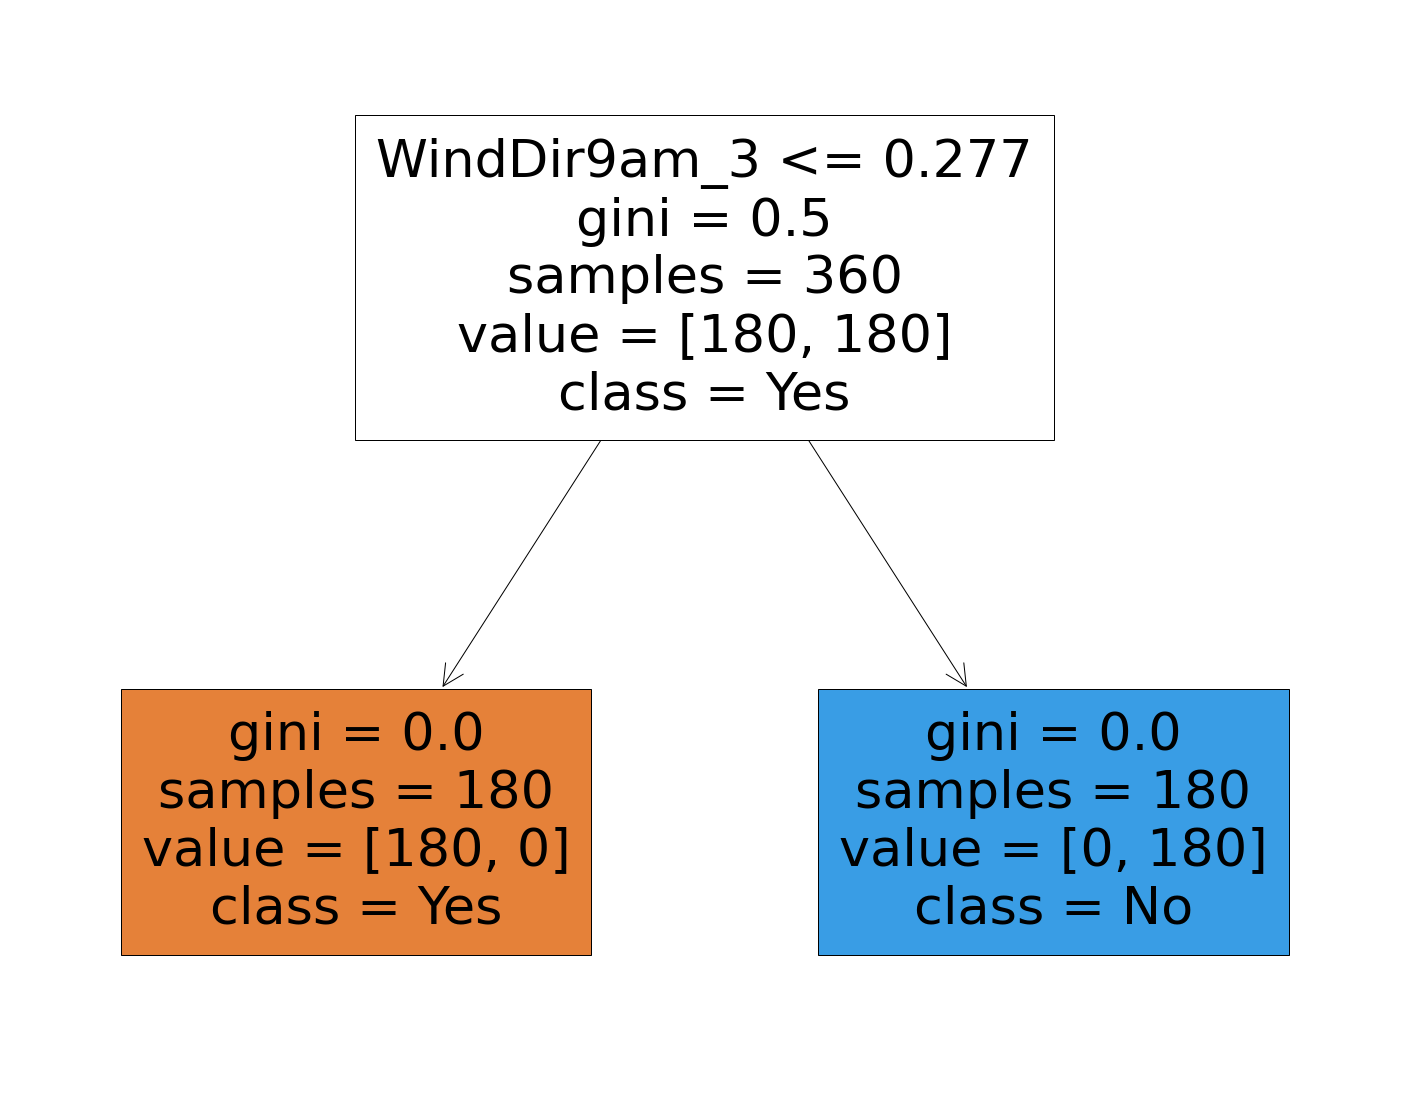

In [42]:
from sklearn import tree
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(tree_clf, 
                   feature_names=X.columns.to_list(),  
                   class_names=['Yes', 'No'],
                   filled=True)

### 4- `K Nearest Neighbour (KNN)`

In [48]:
from sklearn.neighbors import KNeighborsClassifier

# Number of neighbours
n_neighbors = [2, 3, 5, 7]

# Power parameter for the Minkowski metric
p = [1, 2]   # For manhattan and euclidean distance

# Weight function used in prediction.
weights = ['uniform', 'distance']

random_grid = {'n_neighbors': n_neighbors,
               'p': p,
               'weights': weights}

scorer = make_scorer(f1_score)
knn_clf = KNeighborsClassifier(n_jobs=-1)

In [49]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = knn_clf, 
                           param_grid = random_grid, 
                           scoring = scorer, 
                           n_jobs = -1, 
                           verbose = 2).fit(new_X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


E:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [50]:
# Best hyperparameters from the grid search
grid_search.best_params_

{'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}

In [51]:
# Tuned KNN
knn = KNeighborsClassifier(n_neighbors=2, weights='uniform', p=2, n_jobs=-1)
knn.fit(new_X_train, y_train)
knn_y_pred = knn.predict(new_X_test)
print("Train F1_Score: ", f1_score(y_train, knn.predict(new_X_train)))
print("Test F1_Score: ", f1_score(y_test, knn_y_pred))

Train F1_Score:  1.0
Test F1_Score:  1.0


E:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


## Model evaluation

### Train

E:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


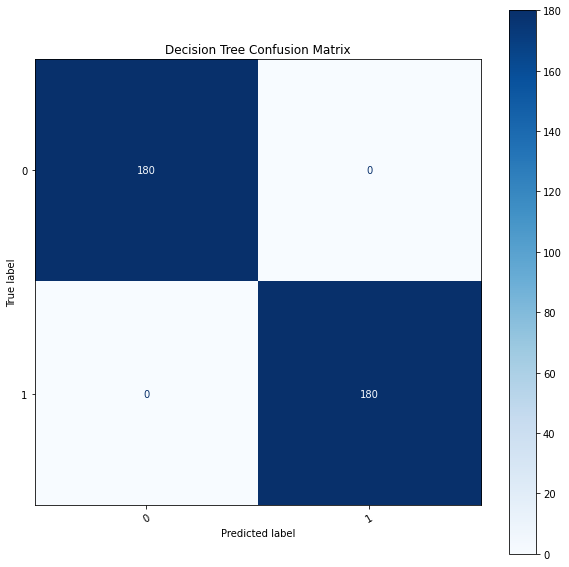

In [44]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(tree_clf, new_X_train, y_train, ax=ax, cmap='Blues')  
plt.xticks(rotation=30)
plt.title('Decision Tree Confusion Matrix')
plt.show() 

In [45]:
train_preds = tree_clf.predict(new_X_train)
report_cb = classification_report(y_train, train_preds, output_dict=True)
report = pd.DataFrame(report_cb).transpose()
report

precision  recall  f1-score  support
0                   1.0     1.0       1.0    180.0
1                   1.0     1.0       1.0    180.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0    360.0
weighted avg        1.0     1.0       1.0    360.0

### Test

E:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


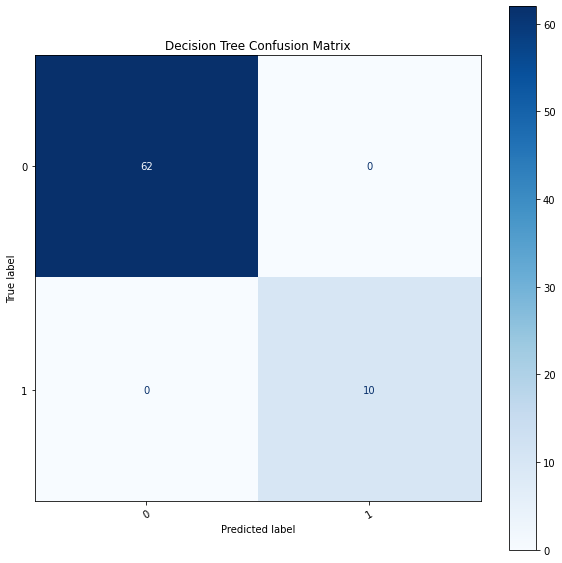

In [46]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(tree_clf, new_X_test, y_test, ax=ax, cmap='Blues')  
plt.xticks(rotation=30)
plt.title('Decision Tree Confusion Matrix')
plt.show() 

In [48]:
test_preds = tree_clf.predict(new_X_test)
report_cb = classification_report(y_test, test_preds, output_dict=True)
report = pd.DataFrame(report_cb).transpose()
report

precision  recall  f1-score  support
0                   1.0     1.0       1.0     62.0
1                   1.0     1.0       1.0     10.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0     72.0
weighted avg        1.0     1.0       1.0     72.0

### <font color=blue>Conclusions</font>
- The dataset is very small, so the results may not describe the real-life situations
- Classes are imbalanced, so either oversampling, undersampling, both of them or any other strategy like providing class weights, can be used to handel this problem
- The classes are seperable using various pairs of features (e.g ('MinTemp', 'RISK_MM'), ("Cloud3pm", "RISK_MM"), .. etc)